# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Библиотеки**

In [84]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import math

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model

import warnings
from sklearn.model_selection import GridSearchCV
import numpy as np

### Шаг 1. Откройте файлы с данными

Выгрузим тренировочные и тестовые данные в переменные data_train и data_test

In [8]:
data_train = pd.read_csv('/datasets/hotel_train.csv')

data_test = pd.read_csv('/datasets/hotel_test.csv')

In [9]:
data_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [10]:
data_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


ВЫВОД:
- Данные коректно выгружены

### Шаг 2. Предобработка и исследовательский анализ данных

**Ищем пропуски**

Выведем информацию о пропусках и типах данных в столбцах

In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [12]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Оба датасета не имеют пропусков, оба содержат 25 столбцов, в тестовом 32412 а в тренировочном 65229 строк

**Ищем дубликаты**

In [13]:
print(data_train.duplicated().sum())
print(data_test.duplicated().sum())

0
0


Явных дубликатов не найдено

**Проверим столбцы на неявные дубликаты**

*Cтолбец `meal`*

In [14]:
data_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [15]:
data_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

Датасеты содержат неявные дубликаты 'SC', причина их появления - это лишние пробелы. Избавимся от них.

In [16]:
data_train['meal'] = data_train['meal'].str.strip()
data_test['meal'] = data_test['meal'].str.strip()

In [17]:
data_train['meal'].value_counts()

BB    51697
HB     7292
SC     5789
FB      451
Name: meal, dtype: int64

In [18]:
data_test['meal'].value_counts()

BB    24684
SC     5293
HB     2399
FB       36
Name: meal, dtype: int64

*Столбец `customer_type`*

In [19]:
data_train['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [20]:
data_test['customer_type'].unique()

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

*Столбец `arrival_date_month`*

In [21]:
data_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [22]:
data_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [23]:
len(data_train['arrival_date_month'].unique())

12

In [24]:
len(data_test['arrival_date_month'].unique())

8

В столбце `arrival_date_month` нет неявных дубликатов, хотя в тестовой выборке месяцев меньше, но как говорится меньше не больше, значит лишнего нет, значит идем дальше, без осени

*Столбец `reserved_room_type`*

In [25]:
data_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [26]:
data_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

In [27]:
data_train['reserved_room_type'] = data_train['reserved_room_type'].str.strip()
data_test['reserved_room_type'] = data_test['reserved_room_type'].str.strip()

In [28]:
data_train['reserved_room_type'].value_counts()

A    50501
D     9387
E     2448
F     1213
B      860
G      592
C      228
Name: reserved_room_type, dtype: int64

In [29]:
data_test['reserved_room_type'].value_counts()

A    23471
D     6123
E     1644
F      503
G      278
C      201
B      192
Name: reserved_room_type, dtype: int64

**Изменение типов данных**

Изменим типы данных в колонках babies, lead_time, adults, children на целочисленные, так как в них содержатся числа

In [30]:
columns = ['babies','lead_time', 'adults', 'children']
tables = [data_test, data_train]
for table in tables:
    for col in columns:
        table[col] = table[col].astype('int64')
    

**Выбросы в данных**

In [31]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


In [32]:
data_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,32412.0,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,0.388467,0.487409,0.0,0.00,0.0,1.00,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.00,76.0,155.00,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.00,2017.0,2017.00,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.00,18.0,25.00,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.00,15.5,23.00,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.00,2.0,3.00,6.0
adults,32412.0,1.858602,0.489341,0.0,2.00,2.0,2.00,4.0
children,32412.0,0.083765,0.343470,0.0,0.00,0.0,0.00,3.0


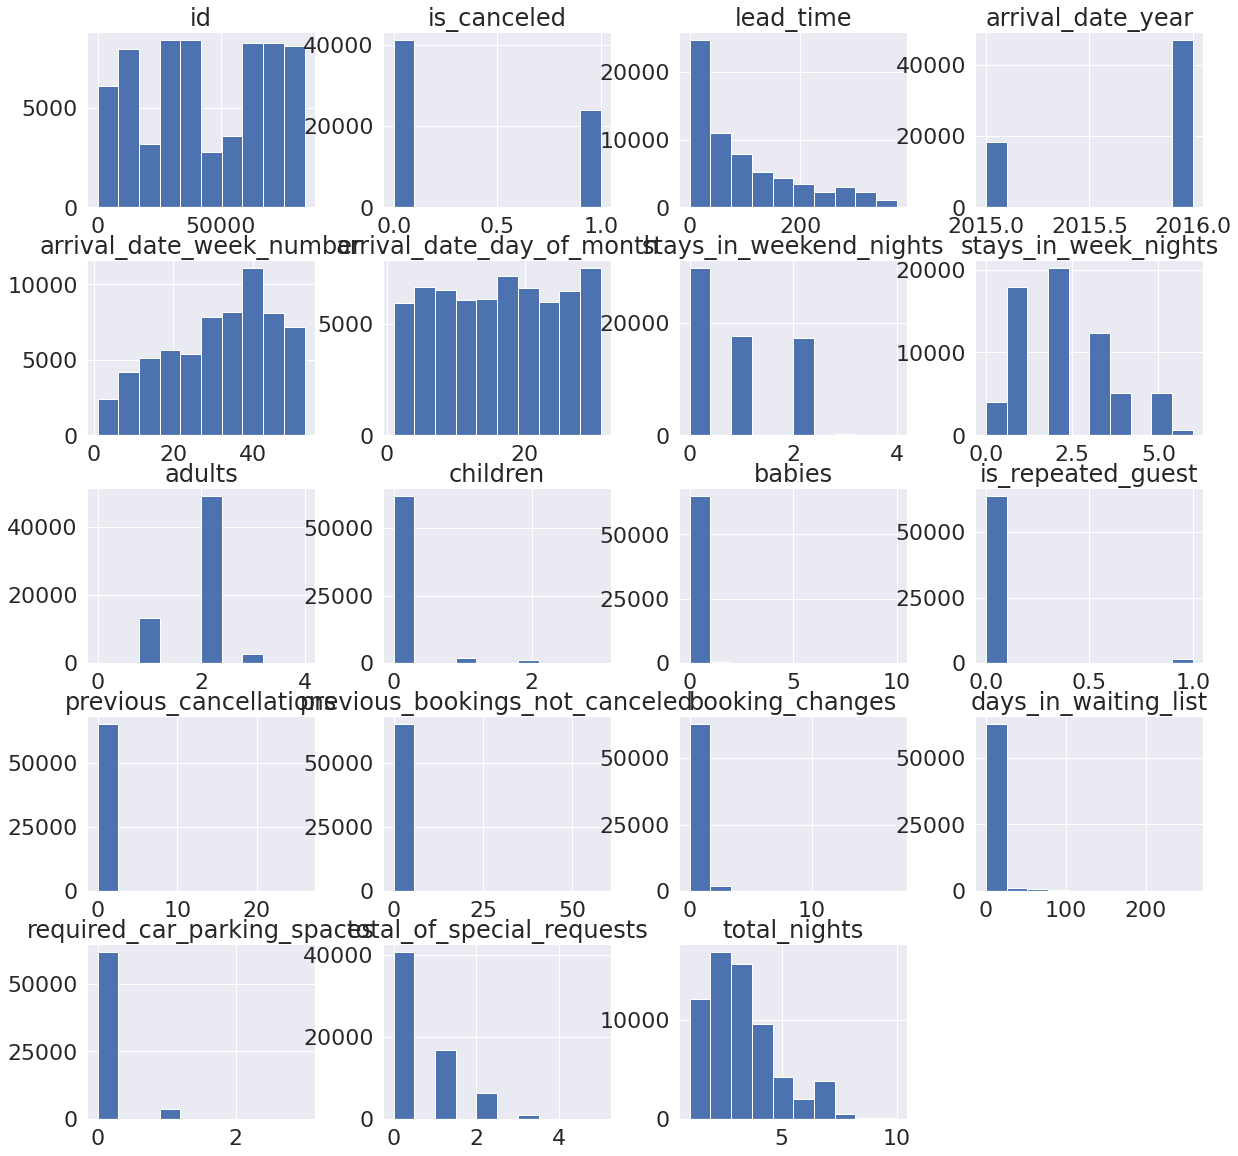

In [33]:
data_train.hist(figsize=(20,20))
plt.show()

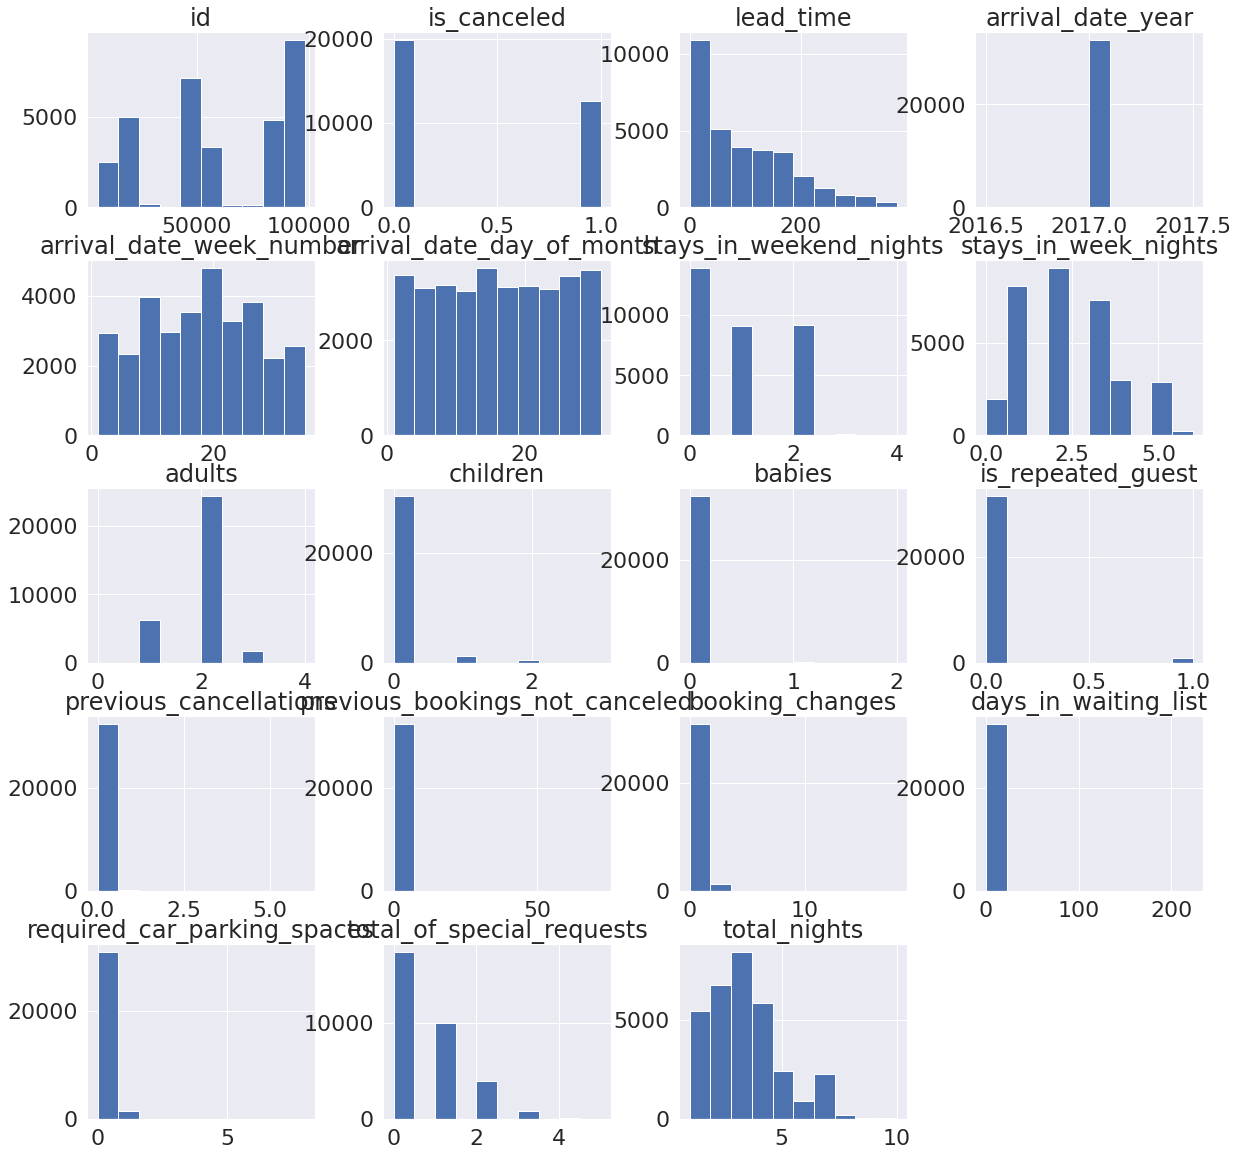

In [34]:
data_test.hist(figsize=(20,20))
plt.show()

In [35]:
#colums = ['id','is_canceled','lead_time','arrival_date_year',\
#         'arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',\
#         'stays_in_week_nights','adults','children','babies','is_repeated_guest',\
#         'previous_cancellations','previous_bookings_not_canceled','booking_changes',\
#         'days_in_waiting_list','required_car_parking_spaces','total_of_special_requests','total_nights']

#for i in colums:
#    data_train[i].plot(kind='hist',figsize=(20,5))
   
#    plt.show()

*Cтолбец `lead_time`*

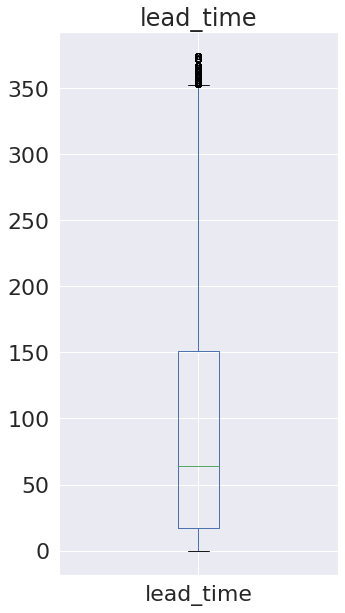

In [36]:
data_train['lead_time'].plot(kind='box',figsize=(5,10), grid=True, legend=True, title='lead_time')
plt.show()

Уберем все что выше 350, так как по диаграмме они не умещаются в межквартильный размах, являются выбросами и составляют всего 567 строк, что меньше 1%

In [37]:
data_train.query('lead_time>350')['lead_time'].count()

567

In [38]:
data_train = data_train.query('lead_time<350')

Построим такую же диаграмму для тестовой выборки

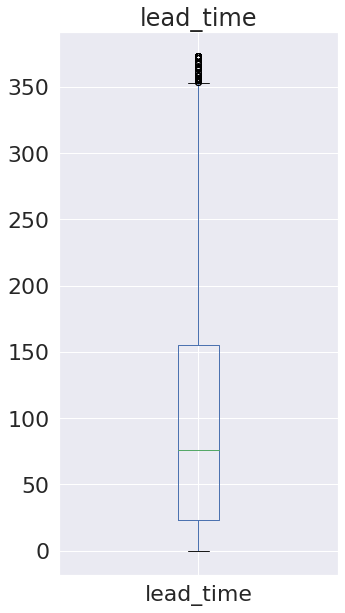

In [39]:
data_test['lead_time'].plot(kind='box',figsize=(5,10), grid=True, legend=True, title='lead_time')
plt.show()

Аналогичная ситуация, удаляем удаляем удаляем

In [40]:
data_test = data_test.query('lead_time<350')

*Cтолбец `adults`*

In [41]:
data_train[data_train['adults'] == 0]['adults'].count()

166

In [42]:
data_test[data_test['adults'] == 0]['adults'].count()

68

В данных есть поля с нулевым количеством взрослых людей, удалим их

In [43]:
data_train = data_train.query('adults!=0')
data_test = data_test.query('adults!=0')

*Cтолбец `babies`*

In [44]:
data_train['babies'].value_counts()

0     63975
1       443
2         3
9         1
10        1
Name: babies, dtype: int64

Так как посетители с 9 и 10 детьми сильно удалились от других, предположим что это выброс

In [45]:
data_train = data_train.query('babies < 9')

In [46]:
data_test['babies'].value_counts()

0    31965
1      169
2        4
Name: babies, dtype: int64

*Cтолбец `required_car_parking_spaces`*

In [47]:
display(data_test['required_car_parking_spaces'].value_counts())
display(data_train['required_car_parking_spaces'].value_counts())

0    30664
1     1465
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

0    60754
1     3655
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

Показатель required_car_parking_spaces отвечает за необходимость наличия парковочного места для автомобиля, а не их количества, и принимает только значения 0 и 1, поэтому удалим все другие значения.

In [48]:
data_train = data_train.query('required_car_parking_spaces < 2')
data_test = data_test.query('required_car_parking_spaces < 2')

*Столбец `booking_changes`*

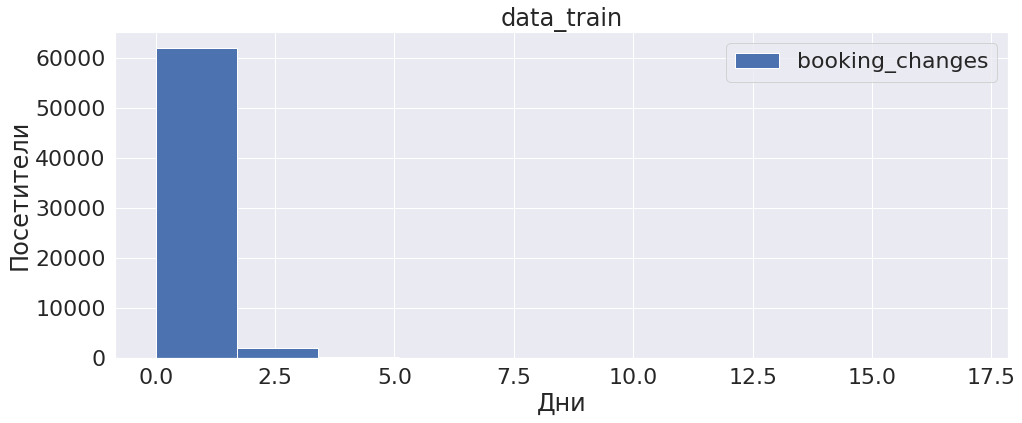

In [49]:
data_train['booking_changes'].plot(kind='hist',figsize=(16,6), legend=True, title='data_train')

plt.xlabel('Дни')
plt.ylabel('Посетители')
plt.show()

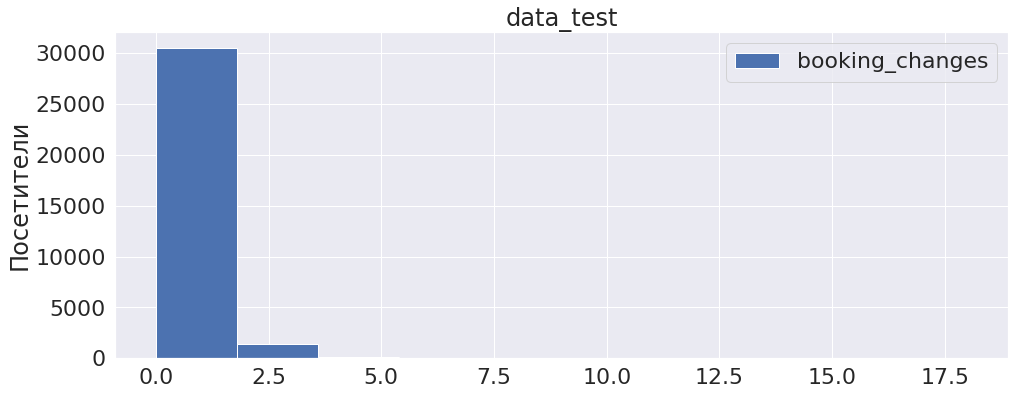

In [50]:
data_test['booking_changes'].plot(kind='hist',figsize=(16,6), legend=True, title='data_test')
#plt.xlabel('Дни')
plt.ylabel('Посетители')
plt.show()

Будем считать выбросами максимальные значения выше 5

In [51]:
data_train = data_train.query('booking_changes < 6')
data_test = data_test.query('booking_changes < 6')

*Столбец `days_in_waiting_list`*

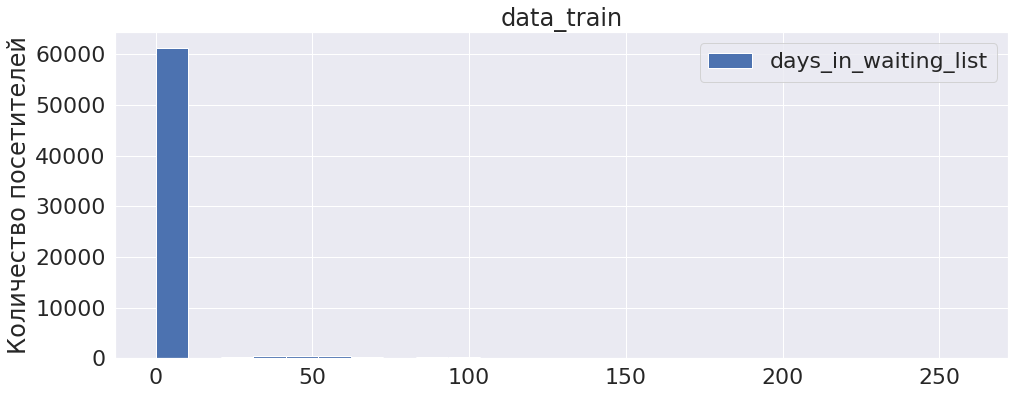

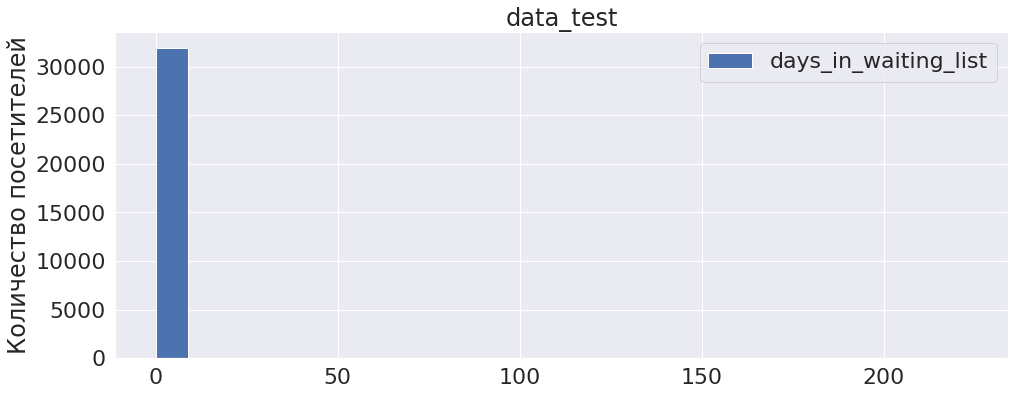

In [52]:
data_train['days_in_waiting_list'].plot(kind='hist', bins=25, figsize=(16,6), legend=True, title='data_train')
#plt.xlabel('Дни ожидания подтверждения')
plt.ylabel('Количество посетителей')

plt.show()
data_test['days_in_waiting_list'].plot(kind='hist', bins=25, figsize=(16,6), legend=True, title='data_test')
#plt.xlabel('Дни ожидания подтверждения')
plt.ylabel('Количество посетителей')
plt.show()

Аномально долгими сроками будем считать больше 2 месяцев

In [53]:
data_train = data_train.query('days_in_waiting_list < 61')
data_test = data_test.query('days_in_waiting_list < 61')

In [54]:
display(data_train.shape[0])
display(data_test.shape[0])

63010

32053

После очистки и преобразования данных осталось:
- В тренировочных данных 63010 строк (96,59% от начальных, потери меньше 4%)
- В тестовых данных 32053 строк (98,89% от начальных, потери меньше 2%)

**Корреляция признаков**

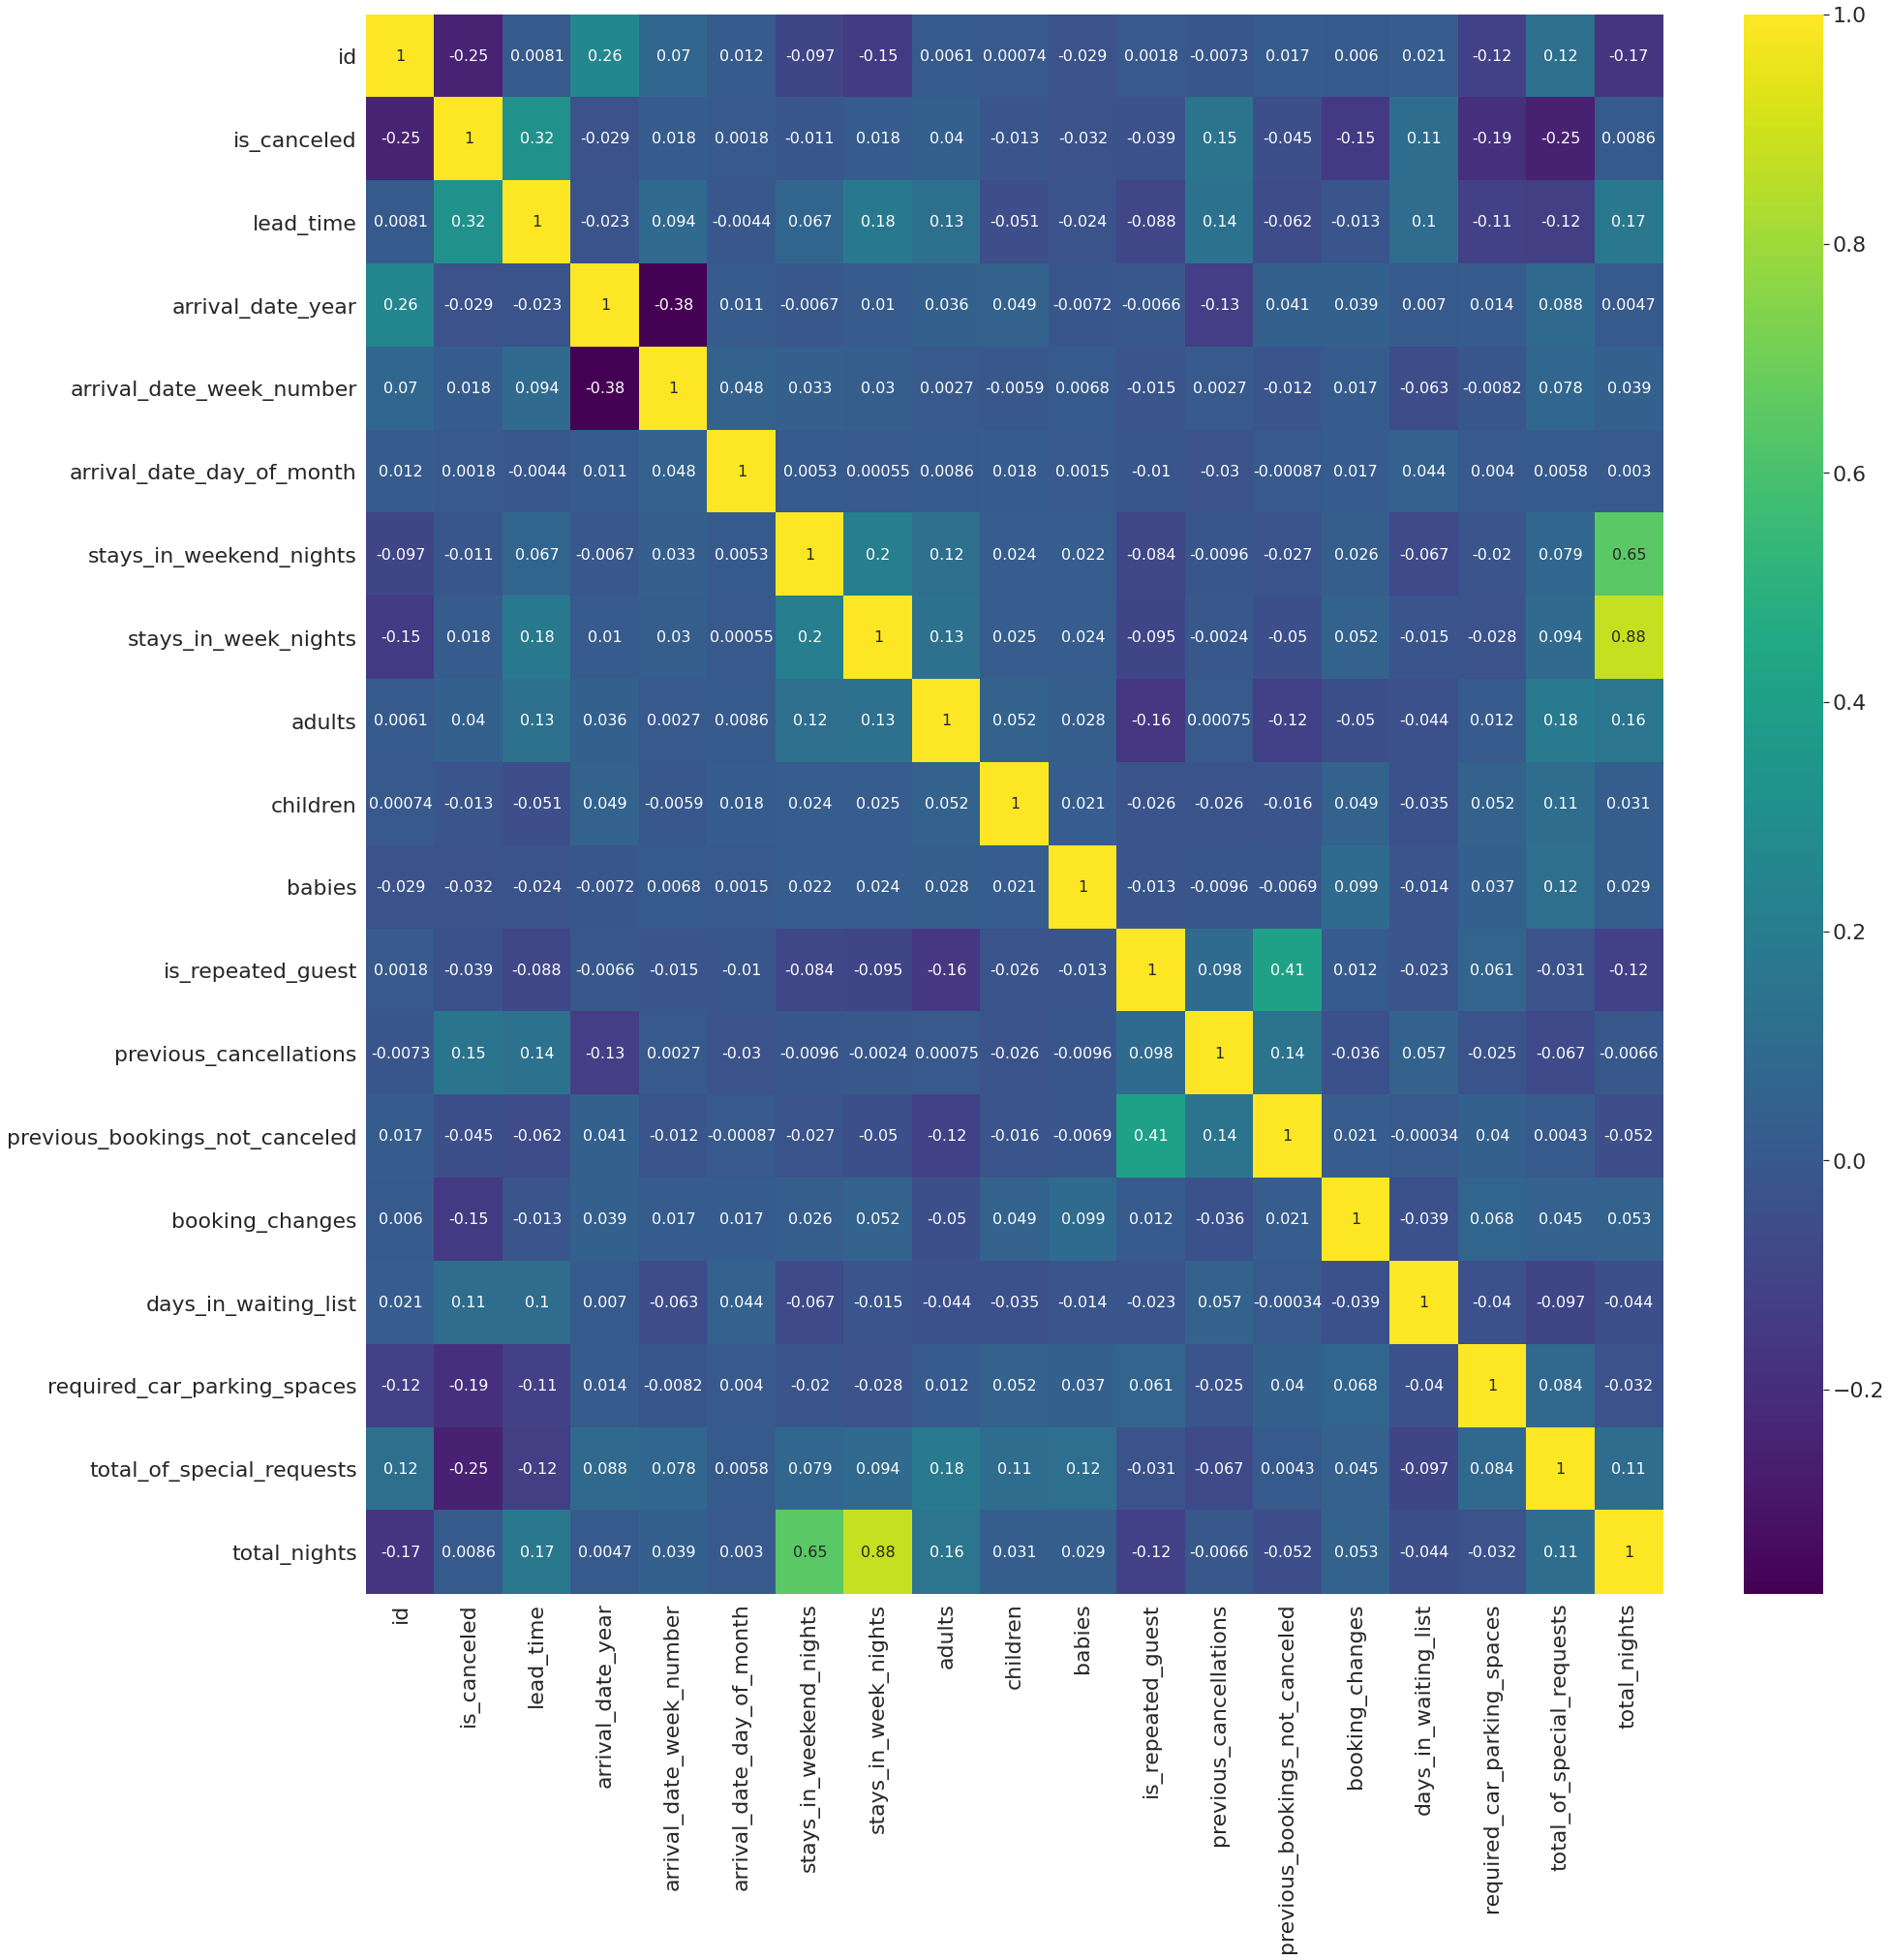

In [55]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(data_train.corr(), annot = True, fmt='.2g', cmap= 'viridis', annot_kws={"fontsize":16})
plt.show()

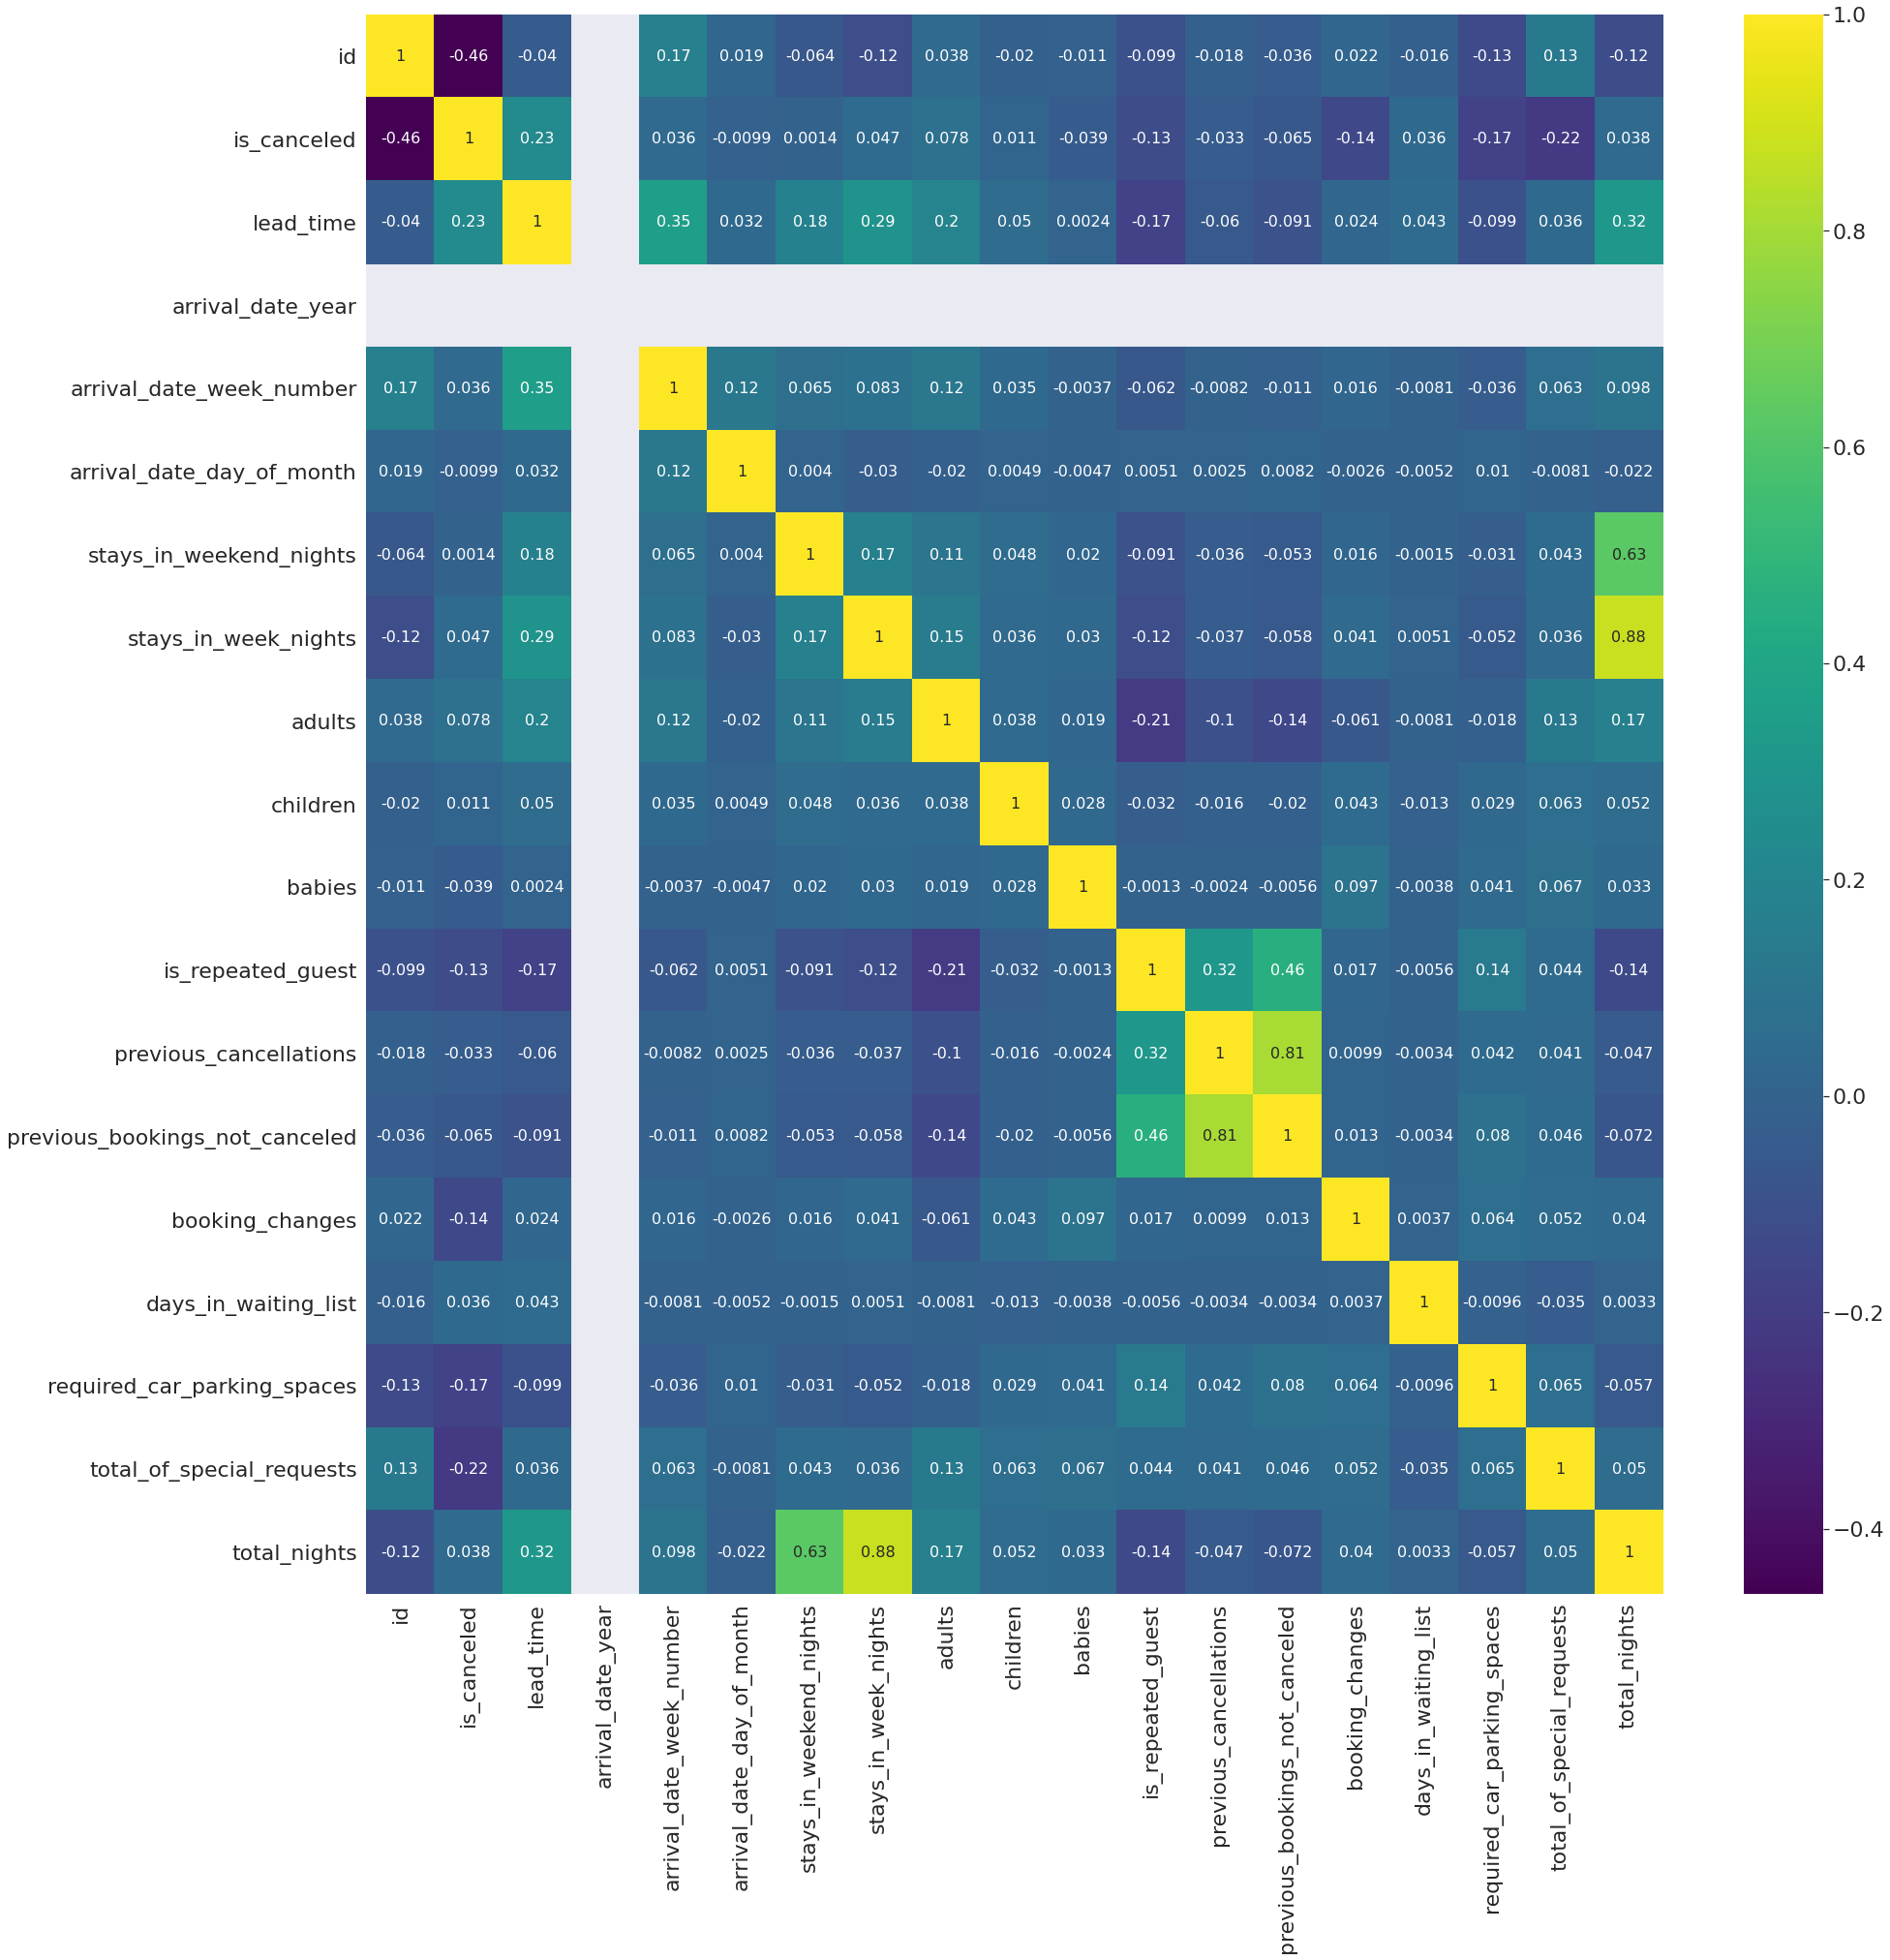

In [56]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(data_test.corr(), annot = True, fmt='.2g', cmap= 'viridis', annot_kws={"fontsize":16})
plt.show()

Как не странно есть корреляция между количеством ночей в выходные дни, количеством ночей в будние дни и общим количеством ночей.

Вывод:
- Были найдены и удалены дубликаты
- Был скорректирован тип данных в столбцах
- Были постоенны гистограммы и мартицы корреляции и исследованны показатели
- Удалили выбросы и аномальные значения из столбцов: 'lead_time' (значения от 350 и выше), 'adults' (равные 0), 'babies' (равные 9 и 10), 'required_car_parking_spaces' (от 2 и выше), booking_changes (от 6 и выше), 'days_in_waiting_list' ( от 61 и выше).

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

*Стоимость номеров отеля:*
- категория `A`: за ночь — 1 000, разовое обслуживание — 400;
- категория `B`: за ночь — 800, разовое обслуживание — 350;
- категория `C`: за ночь — 600, разовое обслуживание — 350;
- категория `D`: за ночь — 550, разовое обслуживание — 150;
- категория `E`: за ночь — 500, разовое обслуживание — 150;
- категория `F`: за ночь — 450, разовое обслуживание — 150;
- категория `G`: за ночь — 350, разовое обслуживание — 150.

Занесем данные в таблицу

In [57]:
columns = ['reserved_room_type' , 'room_price', 'room_prepare']
data = [['A', 1000, 400],['B', 800, 350], ['C', 600, 350], ['D', 550, 150], 
        ['E', 500, 150], ['F', 450, 150], ['G', 350, 150]]
room_data = pd.DataFrame(data=data, columns = columns)

In [58]:
display(room_data)

,reserved_room_type,room_price,room_prepare
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


Создадим функцию для подсчета прибыли, с учетом сезонных изменений цен

In [59]:
summer = ['June', 'July', 'August']
winter = ['December', 'January', 'February']

def count_revenue(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    week_nights = row['stays_in_week_nights']
    weekend_nights = row['stays_in_weekend_nights']
    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
   
    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()
    
    total_nights = week_nights + weekend_nights
    if (row['is_canceled'] == 0):
        
        prepare_nights = math.floor((total_nights-1)/2)
        
        if (month in summer):
            revenue = 1.4*price*total_nights - prepare_cost - prepare_nights*prepare_cost

        elif (month in winter):
            revenue = price*total_nights - prepare_cost - prepare_nights*prepare_cost

        else:
            revenue = 1.2 * price*total_nights - prepare_cost - prepare_nights*prepare_cost
    else:
        revenue = - prepare_cost
    return revenue

In [60]:
total_revenue = data_train.apply(count_revenue, axis=1).sum()
print(total_revenue)

96982760.0


In [61]:
total_revenue = data_test.apply(count_revenue, axis=1).sum()
print(total_revenue)

48601530.0


ВЫВОД:
- На тестовой выборке прибыль составила 48601530.0
- На обучающей 96982760.0

### Шаг 4. Разработка модели ML

Обучим модель классификации, в качестве целевого признака возьмем столбец `is_canceled`, в качестве обучающих признаков будем использовать столбцы 'adults', 'arrival_date_week_number', 'babies', 'country', `'children'`,`'customer_type'`,`'days_in_waiting_list'`,`'is_repeated_guest'`, `'lead_time'`, `'meal'`, `'previous_bookings_not_canceled'`,`'previous_cancellations'`, `'required_car_parking_spaces'`, `'reserved_room_type'`, `'stays_in_weekend_nights'`,`'stays_in_week_nights'`, `'total_of_special_requests'`, `'is_canceled'`.

In [62]:
columns_features = ['adults', 'arrival_date_week_number', 'babies', 'children', 'customer_type', 'country',
                    'days_in_waiting_list', 'is_repeated_guest', 'lead_time', 'meal', 'previous_bookings_not_canceled',
                   'previous_cancellations', 'required_car_parking_spaces', 'reserved_room_type', 'stays_in_weekend_nights',
                   'stays_in_week_nights', 'total_of_special_requests', 'is_canceled' ]
data_train_ohe = data_train[columns_features]
data_test_ohe = data_test[columns_features]

In [63]:
target_train = data_train_ohe['is_canceled']
target_test = data_test_ohe['is_canceled']
features_train = data_train_ohe.drop('is_canceled', axis=1)
features_test = data_test_ohe.drop('is_canceled', axis=1)

Применим технику OneHotEncoder, чтобы преобразовать категориальные переменные в количественные.

In [64]:
enc = OneHotEncoder(handle_unknown='ignore')

In [65]:
enc.fit(features_train)
features_train = enc.transform(features_train) 
features_test = enc.transform(features_test)

**Логистическая регрессия:**

In [66]:
scaler = StandardScaler(with_mean=False)
scaler.fit(features_train) 

StandardScaler(with_mean=False)

In [67]:
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [85]:
warnings.filterwarnings("ignore")

model = LogisticRegression(random_state=12345,class_weight='balanced')

parameters = [{'penalty':['l1','l2']}, 
              {'C':[0,1, 0,5, 1, 10]}]
grid_search = GridSearchCV(estimator = model,  
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 5,
                           verbose=0)

grid_search.fit(features_train_scaled, target_train)

print(grid_search.best_params_, grid_search.best_estimator_, grid_search.best_score_)

{'penalty': 'l2'} LogisticRegression(class_weight='balanced', random_state=12345) 0.5157736815289505


ВЫВОД: При регуляризации применили l2-регуляризацию и перебрали гиперпараметры, лучшим оказался мера penalty равная l2, при этом оценка качества модели составляет 0.5157736815289505


СРАВНЕНИЕ МОДЕЛЕЙ :
   - Логистическая регрессия: 0.5157736815289505
   - Решающее дерево : 0.649587
   - Случайный лес: 0.598767

Убрала в комментарии все Лассо и прочие, добавила регуляризацию и подбор параметров в логистическую регрессию (увидишь, там теперь есть l2-регуляризация). Сравни эту модель с остальными, добавь выводы по ней и убери лишний код) И присылай обратно)

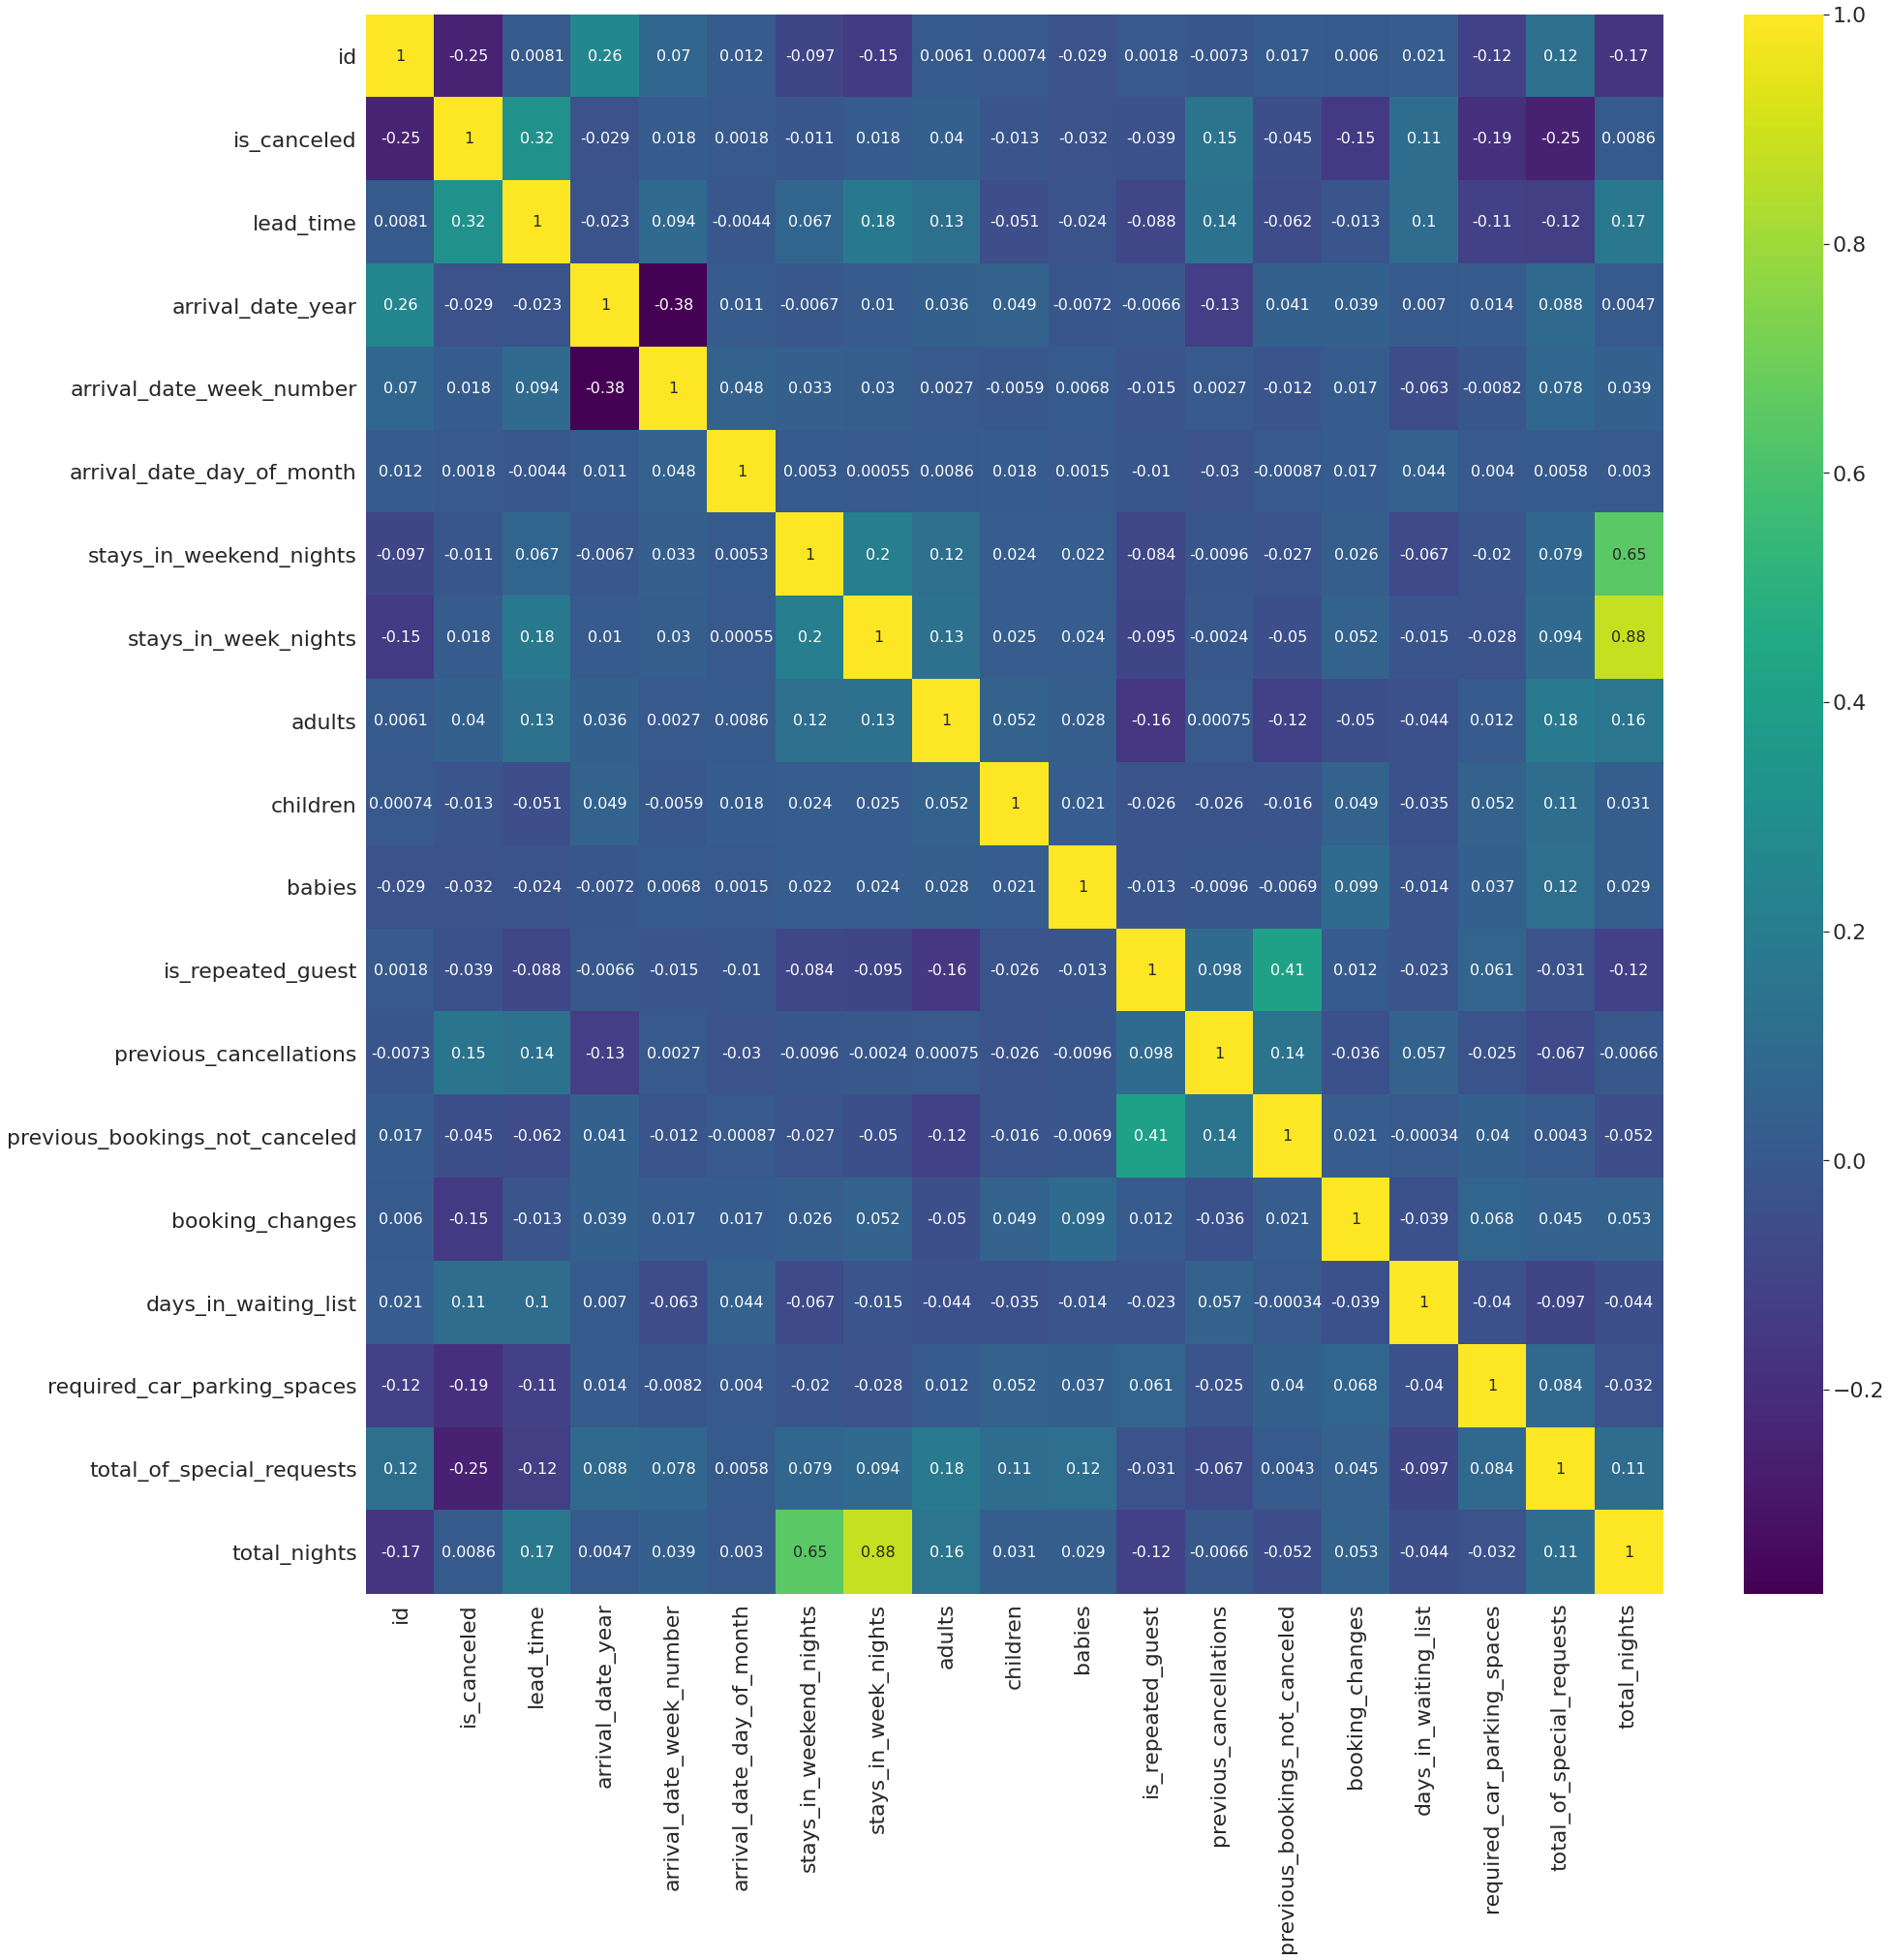

In [69]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(data_train.corr(), annot = True, fmt='.2g', cmap= 'viridis', annot_kws={"fontsize":16})
plt.show()

**Решающее дерево:**

In [70]:
col = ['max_depth', 'final_score']
data = []

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    scores = cross_val_score(model,features_train, target_train, cv=5 , scoring='f1')
    final_score = sum(scores)/len(scores)
    data.append([depth, final_score])
table = pd.DataFrame(data = data, columns=col)
display(table[table['final_score']==table['final_score'].max()]) 

,max_depth,final_score
4,5,0.649587


Лучшая глубина 5, при этом лучшая оценка качества почти 0,65, что лучше чем у логистической регрессии

**Случайный лес:**

In [71]:
col = ['n_estimators', 'final_score']
data = []

for est in range(1,200,50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced',max_depth=5) 
    scores = cross_val_score(model,features_train, target_train, cv=5, scoring='f1')
    final_score = sum(scores)/len(scores)
    data.append([est, final_score])
table = pd.DataFrame(data = data, columns=col)
display(table[table['final_score']==table['final_score'].max()]) 

,n_estimators,final_score
2,101,0.598767


Увеличил лес, сломаляся компуктер :с вернул глубину, иначе проект не работает

Лучшая модель - решающее дерево с глубиной 5.

Проверим ее на тестовой выборке измеряя F1-меру и метрику AUC-ROC.

'Значение F1-меры на тестовой выборке:'

0.6342483461333739

'Значение метрики AUC-ROC:'

0.7750267315926413

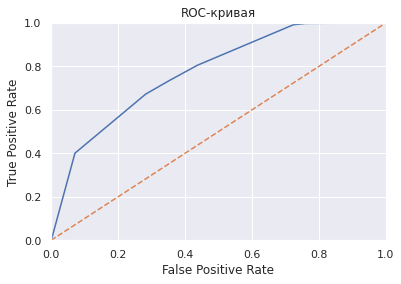

In [72]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)


predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_f1_score = f1_score(target_test, predicted_test )
auc_roc = roc_auc_score(target_test, probabilities_one_test)

display('Значение F1-меры на тестовой выборке:', test_f1_score) 
display('Значение метрики AUC-ROC:', auc_roc)

sns.set(font_scale=1)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Таким образом, модель решающего дерева при величине гиперпараметра max_depth=5 показывает на тестовой выборке следующие результаты:

- F1-мера - 0.634
- Метрика AUC-ROC - 0.775

**Проверим нашу модель на адекватность dummy методом**

In [73]:
names = ['stratified', 'most_frequent', 'prior', 'uniform']
data = []
col = ['name',  'f1_score_test', 'auc_roc_test']
for name in names:
    new_dummy_classifier = DummyClassifier(strategy=name)
    new_dummy_classifier.fit(features_train, target_train)
    test_predictions = new_dummy_classifier.predict(features_test)
    probabilities_test = new_dummy_classifier.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    test_accuracy = accuracy_score(target_test, test_predictions)
    test_f1_score = f1_score(target_test, test_predictions )
    auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
    data.append([name, test_f1_score, auc_roc_test])
table = pd.DataFrame(data = data, columns=col)
display(table[table['f1_score_test']==table['f1_score_test'].max()]) 

,name,f1_score_test,auc_roc_test
3,uniform,0.434669,0.5


Как видим, показатели у лучшего (при значении параметра strategy='uniform') из фиктивных классификаторов намного ниже, чем у нашей модели, и находятся на уровне 0.43 для F1-меры, а также 0.5- для метрики AUC-ROC.

Таким образом можно заключить, что наша модель прошла тест на адекватность.

**Рассчитаем годовую прибыть**

In [74]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

Сохраним предсказание в таблицу

In [75]:
data_test['predictions'] = predicted_test
display(data_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,predictions
0,6086,1,74,2017,January,1,1,1,0,2,...,0,0,A,0,0,Transient,0,0,1,1
1,6087,1,62,2017,January,1,1,2,2,2,...,0,0,A,0,0,Transient,0,1,4,0
2,6088,1,62,2017,January,1,1,2,2,2,...,0,0,A,0,0,Transient,0,1,4,0
3,6089,1,71,2017,January,1,1,2,2,1,...,0,0,A,0,0,Transient,0,1,4,0
4,6090,1,172,2017,January,1,1,2,5,2,...,0,0,A,0,0,Transient,0,0,7,1


Создадим функцию, которая подсчитает прибыль с условием депозитов:

In [76]:
summer = ['June', 'July', 'August']
winter = ['December', 'January', 'February']

def count_revenue_with_deposit(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    week_nights = row['stays_in_week_nights']
    weekend_nights = row['stays_in_weekend_nights']
    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()
    total_nights = week_nights + weekend_nights
    if (row['predictions']==1):
        deposit = 0.8*price
    else:
        deposit = 0
    
    
    if (row['is_canceled'] == 0):
        
        prepare_nights = math.floor((total_nights-1)/2)
        

        if (month in summer):
            revenue = 1.4*price*total_nights - prepare_cost - prepare_nights*prepare_cost

        elif (month in winter):
            revenue = price*total_nights - prepare_cost - prepare_nights*prepare_cost

        else:
            revenue = 1.2 * price*total_nights - prepare_cost - prepare_nights*prepare_cost
    elif (row['is_canceled'] == 1 and row['predictions'] == 1):
        revenue = -(prepare_cost * 0.2)
    else:
        revenue = - prepare_cost
    return revenue
    

In [77]:
total_revenue_deposit = data_test.apply(count_revenue_with_deposit, axis=1).sum()
print(total_revenue_deposit)

50924610.0


Теперь подсчитаем чистую прибыль отеля после введения системы депозитов с учетом стоимости разработки системы прогнозирования:

In [78]:
IMPLEMENTATION_COST = 400000
net_profit = total_revenue_deposit  - total_revenue - IMPLEMENTATION_COST
print(net_profit)

1923080.0


Таким образом, с учетом стоимости введения системы депозитов, отель за год получит дополнительно 5.595 млн. чистой прибыли

Вывод
- Отель до внедрения системы депозитов за 2017 год получил прибыль 48.60 млн.
- Лучшая модель - решающее дерево при величине гиперпараметра max_depth=5
- Метрики качества на тестовой выборке следующие результаты: F1-мера - 0.634, метрика AUC-ROC - 0.775
- Чистая прибыль после введения депозитов в 2017 году могла стать 50.924 млн
- C учетом стоимости введения системы депозитов, отель за год может получить дополнительно 1.923 млн. чистой прибыли

### Шаг 5. Опишите портрет «ненадёжного» клиента

Проанализируем бронирования, которые модель посчитала отмененными и те, которые действительно ими оказались. Вызовем метод describe, чтобы сразу увидеть медианное значение и квартили:

In [79]:
data_test.query('is_canceled==1 and predictions==True').describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,predictions
count,8341.000000,8341.0,8341.000000,8341.0,8341.000000,8341.000000,8341.000000,8341.000000,8341.000000,8341.000000,8341.000000,8341.000000,8341.000000,8341.000000,8341.000000,8341.000000,8341.0,8341.0,8341.000000,8341.0
mean,44000.446589,1.0,118.900611,2017.0,17.618511,15.656036,0.837190,2.349838,1.878192,0.073972,0.000959,0.001918,0.002158,0.006474,0.073852,0.291931,0.0,0.0,3.187028,1.0
std,15101.163230,0.0,78.174062,0.0,8.402082,8.670785,0.853888,1.271679,0.467690,0.333817,0.030957,0.043758,0.069221,0.302597,0.364574,3.386993,0.0,0.0,1.557000,0.0
min,6086.000000,1.0,0.000000,2017.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.0
25%,46183.000000,1.0,56.000000,2017.0,11.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.000000,1.0
50%,49070.000000,1.0,110.000000,2017.0,18.000000,15.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.000000,1.0
75%,51927.000000,1.0,169.000000,2017.0,24.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.000000,1.0
max,91576.000000,1.0,349.000000,2017.0,35.000000,31.000000,4.000000,6.000000,4.000000,3.000000,1.000000,1.000000,4.000000,26.000000,5.000000,60.000000,0.0,0.0,10.000000,1.0


На основе медиан и значений квартилей можно сказать, что "ненадежный" клиент:

- бронирует номер заранее, в основном - за 106 дней
- бронирует в основном номер на 3 ночи: 1 приходится на выходные, 2 - на будние
- это двое взрослых без детей и младенцев
- никогда не был клиентом отеля, не отменял и не заказывал номера ранее
- не указывает специальные отметки, не вносит правки в бронь
- не запрашивает парковочное место

Проанализируем столбцы, содержащие категориальные переменные:

In [80]:
data_test.query('is_canceled==1 and predictions==True')['customer_type'].value_counts(normalize=True)

Transient          0.916557
Transient-Party    0.078648
Contract           0.004076
Group              0.000719
Name: customer_type, dtype: float64

В 94% случаев тип ненадежного клиента не связан с с договором или групповым заездом.

In [81]:
data_test.query('is_canceled==1 and predictions==True')['meal'].value_counts(normalize=True)

BB    0.826520
SC    0.120849
HB    0.051073
FB    0.001559
Name: meal, dtype: float64


В 77% случаев выбирают только завтраки, в 94% - завтраки или ничего.

In [82]:
data_test.query('is_canceled==1 and predictions==True')['reserved_room_type'].value_counts(normalize=True)

A    0.786716
D    0.148543
E    0.036087
F    0.012469
G    0.008872
C    0.005155
B    0.002158
Name: reserved_room_type, dtype: float64

В 3 из 4 бронирований ненадежные клиенты предпочитают номера типа А.

In [83]:
data_test.query('is_canceled==1 and predictions==True')['distribution_channel'].value_counts(normalize=True)

TA/TO        0.903489
Direct       0.051073
Corporate    0.044119
GDS          0.001319
Name: distribution_channel, dtype: float64

В 92% случаев, канал дистрибуции был - TA/TO .

Вывод
Портрет ненадежного клиента выглядит следующим образом:

- бронирует номер заранее, в основном - за 106 дней
- бронирует в основном номер на 3 ночи: 1 приходится на выходные, 2 - на будние
- это двое взрослых без детей и младенцев
- никогда не был клиентом отеля, не отменял и не заказывал номера ранее
- не указывает специальные отметки, не вносит правки в бронь
- не запрашивает парковочное место
- не связан с договором или групповым заездом
- вместе с номером выбирает включенный в стоимость завтрак или ничего
- выбирает самый дорогую по стоимости категорию номера (А)
- канал дистрибуции - TA/TO

### Шаг 6. Напишите общий вывод


Лучшая модель - решающее дерево при величине гиперпараметра max_depth=5. Её метрики качества на тестовой выборке: F1-мера - 0.634, метрика AUC-ROC - 0.755.

Благодаря внедрению системы депозитов и работе модели можно было увеличить чистую прибыль в 2017 году на 7.537 млн. (и это с учетом стоимости разработки модели).

Бизнесу можно рекомендовать:

1) ввести систему депозитов

2) использовать модель для предсказания отказа от брони

3) вне зависимости от работы модели ввести обязательный депозит для клиентов, которые бронируют номера больше, чем за 3 месяца.